In [1]:
from tensorflow import keras
from tensorflow.keras import datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# Prática 2 - CIFAR 10

Semelhantemente ao MNIST, agora utilizaremos outra base de dados disponível no tensorflow.
Desta vez, utilizaremos o CIFAR10, base de dados que possui 10 classes divididas em animais e meios de transporte.

De forma geral, podemos pensar neste dataset como:
* Complexidade moderada: os objetos estão em diferentes posições e ângulos. Existe também uma variabilidade dos objetos. Se olharmos para a classe "bird" por exemplo, ela vai desde pássaros, galinhas, até avestruz. Também existe um background diferenciado a cada imagem, aumentando também um pouco a complexidade do modelo.
* Processamento rápido: as imagens são pequenas (32x32), apesar de imagens serem coloridas (3 canais de cores)

![Title](imgs/cifar10_dataset.png) 

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

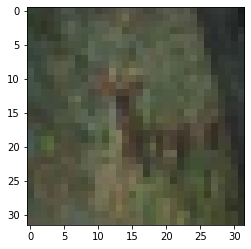

In [3]:
# pick a sample to plot
sample = 10
image = x_train[sample]

# plot the sample
fig = plt.figure
plt.imshow(image)
plt.show()

### Normalização

In [4]:
m = np.max(x_train)
x_train = x_train/m
x_test = x_test/m

### One hot encoder

In [5]:
hot = OneHotEncoder()
y_train = hot.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test = hot.transform(y_test.reshape(-1, 1)).toarray()

### Treino e Validação

In [6]:
from sklearn.model_selection import train_test_split

x_treino, x_val, y_treino, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state = 13)
x_treino.shape, x_val.shape, x_test.shape, y_treino.shape, y_val.shape, y_test.shape

# 3 camadas: não precisa adicionar uma camada extra

((40000, 32, 32, 3),
 (10000, 32, 32, 3),
 (10000, 32, 32, 3),
 (40000, 10),
 (10000, 10),
 (10000, 10))

### Arquitetura da rede neural tradicional

In [8]:
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [18]:
rede_simples = Sequential()

rede_simples.add(Flatten())
rede_simples.add(Dense(240, input_dim = 1024*3)) # 32x32x3 - 3 camadas BGR
rede_simples.add(Activation('relu'))
rede_simples.add(Dropout(0.3))
rede_simples.add(Dense(512)) # Podemos aumentar em múltiplos de 2 para os próximos Dense()
rede_simples.add(Activation('relu'))
rede_simples.add(Dropout(0.3))
rede_simples.add(Dense(512))
rede_simples.add(Activation('relu'))
rede_simples.add(Dropout(0.3))
rede_simples.add(Dense(10))
rede_simples.add(Activation('softmax'))

In [19]:
import tensorflow as tf

rede_simples.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics=['accuracy'])

In [20]:
es = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 10, verbose = 1, mode = 'auto')
    
historico = rede_simples.fit(x_treino, 
                             y_treino, 
                             epochs = 150, 
                             batch_size=64,
                             verbose = 1,
                             validation_data = (x_val, y_val),
                             callbacks = [es])

Epoch 1/150
625/625 [==============================] - 8s 11ms/step - loss: 2.0888 - accuracy: 0.2041 - val_loss: 1.9476 - val_accuracy: 0.2383
Epoch 2/150
625/625 [==============================] - 6s 10ms/step - loss: 1.9995 - accuracy: 0.2426 - val_loss: 1.8921 - val_accuracy: 0.2989
Epoch 3/150
625/625 [==============================] - 7s 11ms/step - loss: 1.9812 - accuracy: 0.2558 - val_loss: 1.9043 - val_accuracy: 0.2966
Epoch 4/150
625/625 [==============================] - 7s 11ms/step - loss: 1.9585 - accuracy: 0.2675 - val_loss: 1.8906 - val_accuracy: 0.3015
Epoch 5/150
625/625 [==============================] - 6s 10ms/step - loss: 1.9530 - accuracy: 0.2694 - val_loss: 1.8674 - val_accuracy: 0.3096
Epoch 6/150
625/625 [==============================] - 7s 10ms/step - loss: 1.9439 - accuracy: 0.2740 - val_loss: 1.8579 - val_accuracy: 0.3316
Epoch 7/150
625/625 [==============================] - 7s 11ms/step - loss: 1.9317 - accuracy: 0.2795 - val_loss: 1.9235 - val_accuracy:

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

pred_simples = rede_simples.predict(x_test)
accuracy_score(y_test.argmax(1), pred_simples.argmax(1))

313/313 [==============================] - 1s 3ms/step


0.3517

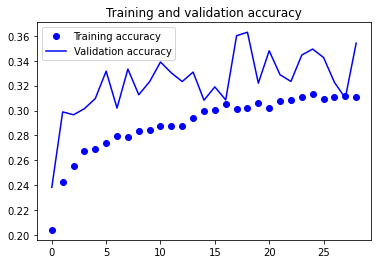

In [22]:
loss = historico.history['accuracy']
val_loss = historico.history['val_accuracy']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_loss, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [17]:
# Maior acurácia
np.max(loss)

0.34834998846054077

----

### Com Feature extraction

In [10]:
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [8]:
x_treino.shape, x_val.shape, x_test.shape, y_treino.shape, y_val.shape, y_test.shape

((40000, 32, 32, 3),
 (10000, 32, 32, 3),
 (10000, 32, 32, 3),
 (40000, 10),
 (10000, 10),
 (10000, 10))

In [14]:
rede_simples = Sequential()
rede_simples.add(Conv2D(100, (5,5), activation = 'relu', input_shape = (32,32,3)))
# Conv2D é ideal se for múltiplos de 2
rede_simples.add(MaxPooling2D())
rede_simples.add(Conv2D(25, (5,5), activation = 'relu'))
rede_simples.add(MaxPooling2D())
rede_simples.add(Flatten())
rede_simples.add(Dense(240, input_dim = 625))
rede_simples.add(Activation('relu'))
rede_simples.add(Dropout(0.3))
rede_simples.add(Dense(512))
rede_simples.add(Activation('relu'))
rede_simples.add(Dropout(0.3))
rede_simples.add(Dense(512))
rede_simples.add(Activation('relu'))
rede_simples.add(Dropout(0.3))
rede_simples.add(Dense(10))
rede_simples.add(Activation('softmax'))

In [15]:
rede_simples.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 100)       7600      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 100)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 10, 10, 25)        62525     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 25)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 625)               0         
                                                                 
 dense_4 (Dense)             (None, 240)              

In [16]:
import tensorflow as tf

rede_simples.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics=['accuracy'])

In [17]:
es = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 10, verbose = 1, mode = 'auto')
    
historico = rede_simples.fit(x_treino, 
                             y_treino, 
                             epochs = 150, 
                             batch_size=64,
                             verbose = 1,
                             validation_data = (x_val, y_val),
                             callbacks = [es])

Epoch 1/150
625/625 [==============================] - 69s 110ms/step - loss: 1.7393 - accuracy: 0.3510 - val_loss: 1.4421 - val_accuracy: 0.4650
Epoch 2/150
625/625 [==============================] - 72s 115ms/step - loss: 1.4698 - accuracy: 0.4628 - val_loss: 1.3935 - val_accuracy: 0.4895
Epoch 3/150
625/625 [==============================] - 72s 115ms/step - loss: 1.3751 - accuracy: 0.5044 - val_loss: 1.2767 - val_accuracy: 0.5413
Epoch 4/150
625/625 [==============================] - 73s 116ms/step - loss: 1.3061 - accuracy: 0.5301 - val_loss: 1.2685 - val_accuracy: 0.5422
Epoch 5/150
625/625 [==============================] - 72s 115ms/step - loss: 1.2530 - accuracy: 0.5494 - val_loss: 1.2333 - val_accuracy: 0.5621
Epoch 6/150
625/625 [==============================] - 74s 118ms/step - loss: 1.2048 - accuracy: 0.5718 - val_loss: 1.1982 - val_accuracy: 0.5683
Epoch 7/150
625/625 [==============================] - 89s 143ms/step - loss: 1.1592 - accuracy: 0.5869 - val_loss: 1.1588 -

In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

pred_simples = rede_simples.predict(x_test)
accuracy_score(y_test.argmax(1), pred_simples.argmax(1))
# np.argmax(1): qual o índice que tem '1' 

313/313 [==============================] - 4s 11ms/step


0.6322

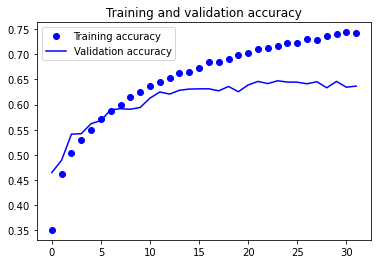

In [19]:
loss = historico.history['accuracy']
val_loss = historico.history['val_accuracy']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_loss, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

---

### Parece que deu overfitting. Reduzir Camadas densas e Dropout com 0.5

---